In [1]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from e6dataflow.datamodel import load_datamodel, get_datamodel
from e6dataflow.tools.fittools import e6_fit
from scipy.optimize import curve_fit
import colorsys


In [2]:
### Load datamodel from .p file
run_name = 'run1'

datamodel = load_datamodel(datamodel_path=Path.cwd(), run_name=run_name)

Loading datamodel from Y:\expdata-e6\analysis\2021\03\06\run1\run1-datamodel.p


In [3]:
### Information about run:
### Note that molasses intensity is less than 5 for the first two frames,
### so better not use mol_freq = 4.5 and 5 for the 1/delta^2 fit!

tweezer_freq_list = [100,102,104,106,108,110,112,114,116,118,120]
num_tweezers = len(tweezer_freq_list)

probe_att_list = [0]
pzt_para_list = [5.5]

num_points = datamodel.num_points #len(pzt_para_list) * len(probe_att_list)


mol_freq_list = [6,5,5.5,6,6.5,7,7.5,7.7]
num_frames = len(mol_freq_list) + 2

num_shots = datamodel.num_shots

num_loops = num_shots // num_points

print(num_points,'points')
print(num_frames,'frames')
print(num_tweezers,'tweezers')
print(num_shots,'shots')
print(num_loops,'complete loops')


t_exposure = 500

t_hold_1 = 100
t_hold_2 = 1000
t_hold_3 = 10000
t_frame_1 = t_exposure + t_hold_1
t_frame_2 = t_exposure + t_hold_2
t_frame_3 = t_exposure + t_hold_3

roi_width = 14
roi_height = 12
roi_area = roi_width * roi_width

1 points
10 frames
11 tweezers
2564 shots
2564 complete loops


In [4]:
counts_array = np.zeros((num_frames,len(probe_att_list),len(pzt_para_list),len(tweezer_freq_list),num_loops))

for point in range(num_points):
    probe_att_counter = point % len(probe_att_list)
    pzt_para_counter = point // len(probe_att_list)
    for frame_num in range(num_frames):
        for twz_counter in range(num_tweezers):
            counts_array[frame_num,probe_att_counter,pzt_para_counter,twz_counter,:]=\
                datamodel.get_data_by_point(f'frame-{frame_num:02d}_tweezer-{twz_counter:02d}_counts',point,\
                                           shots=range(num_loops*num_points))
            
print(counts_array.shape)

(10, 1, 1, 11, 2564)


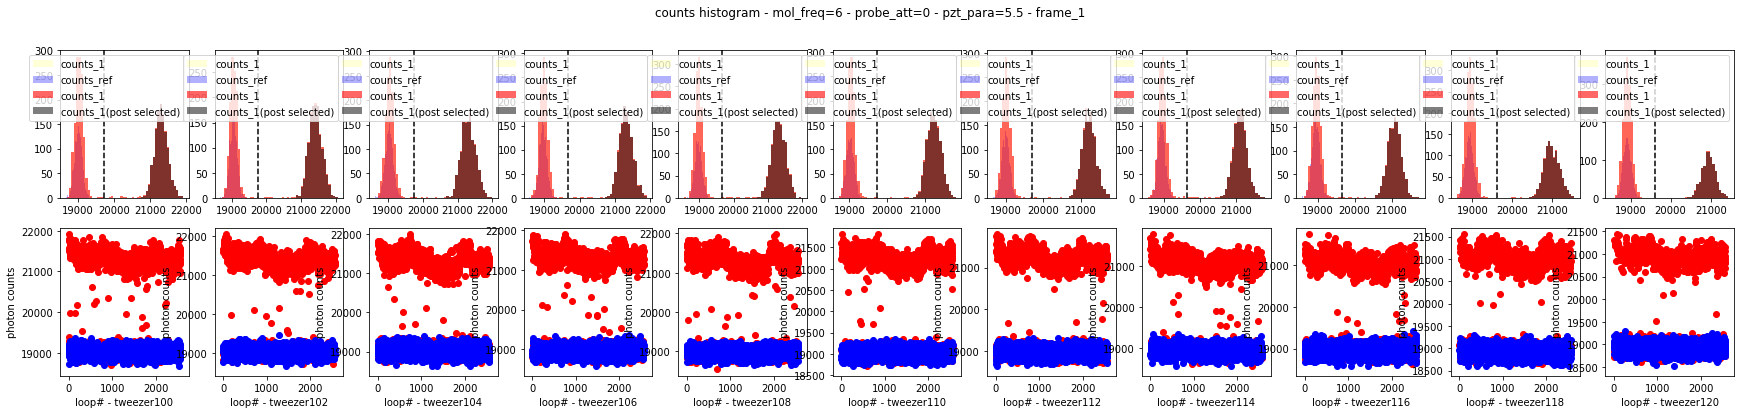

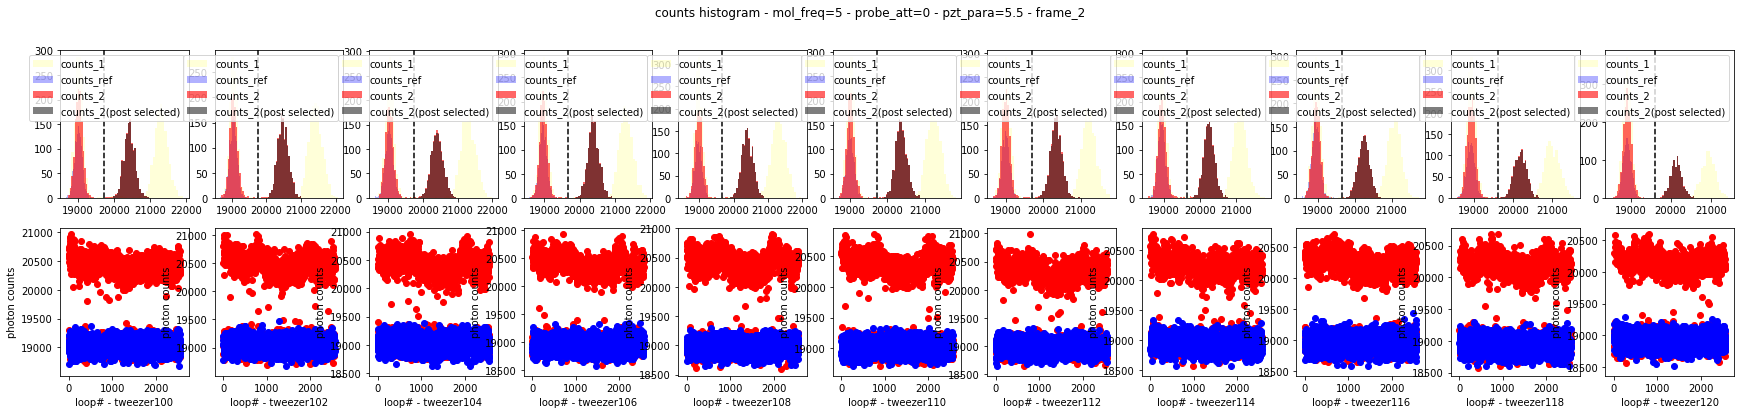

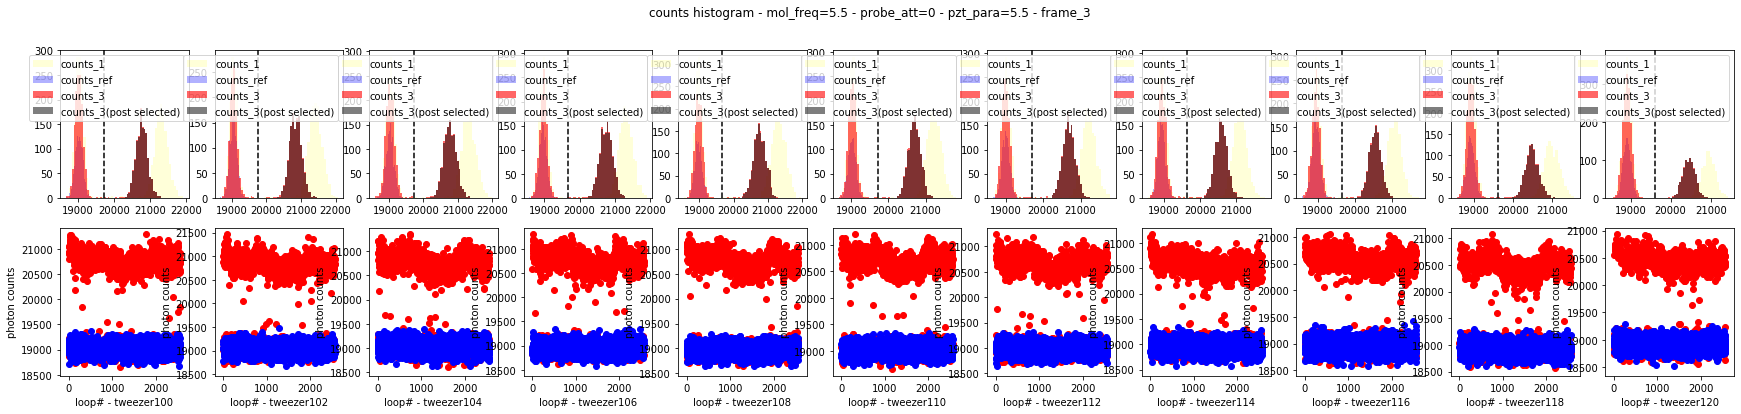

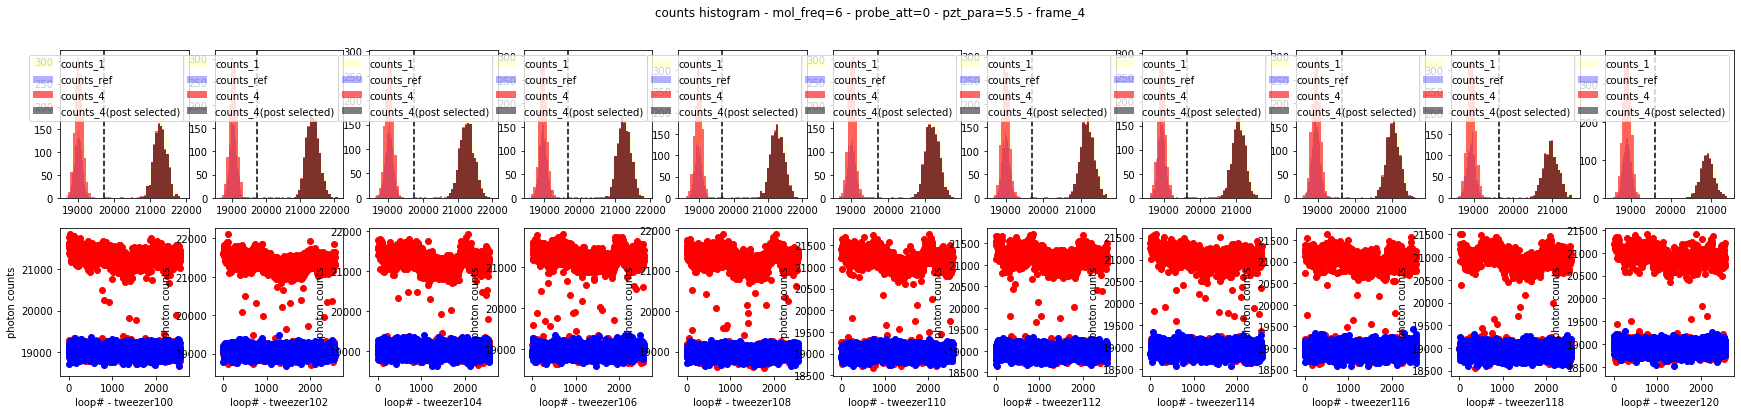

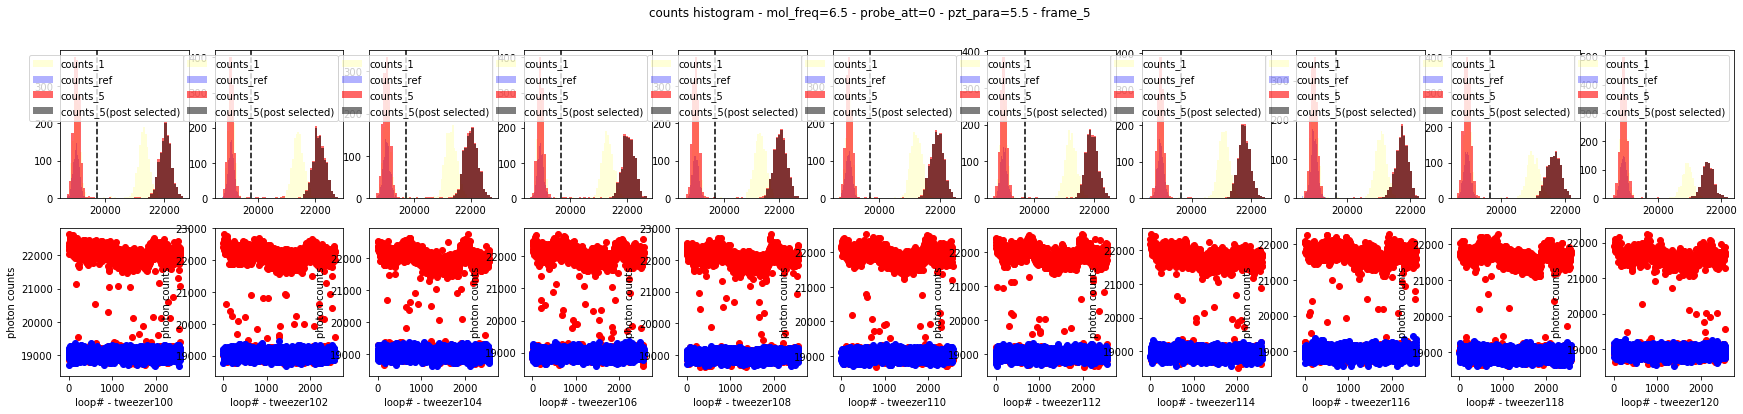

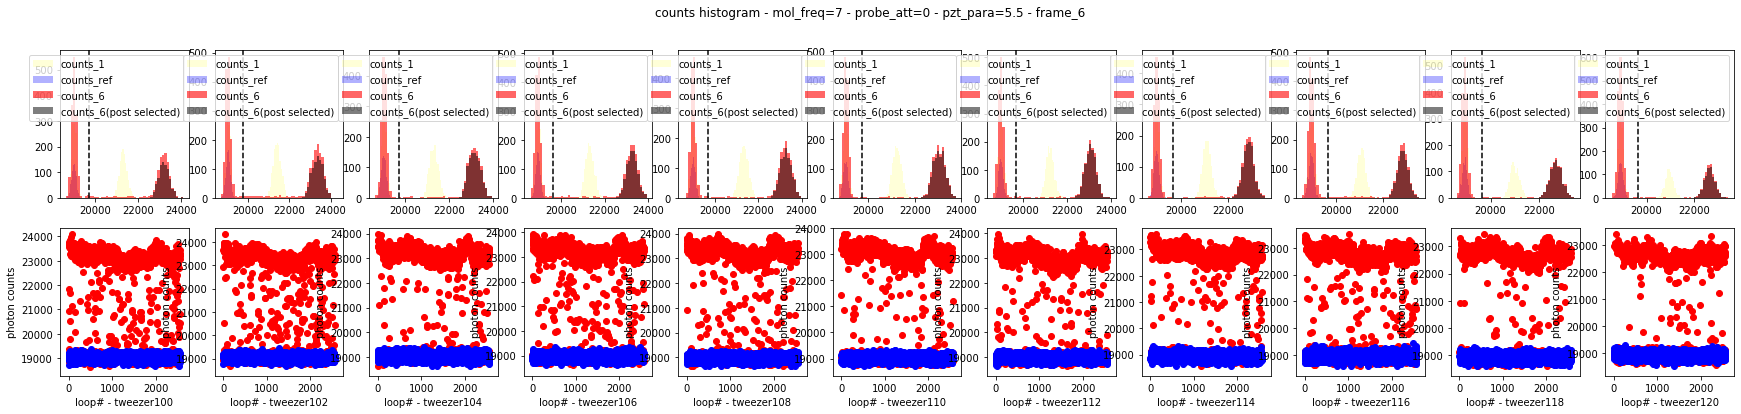

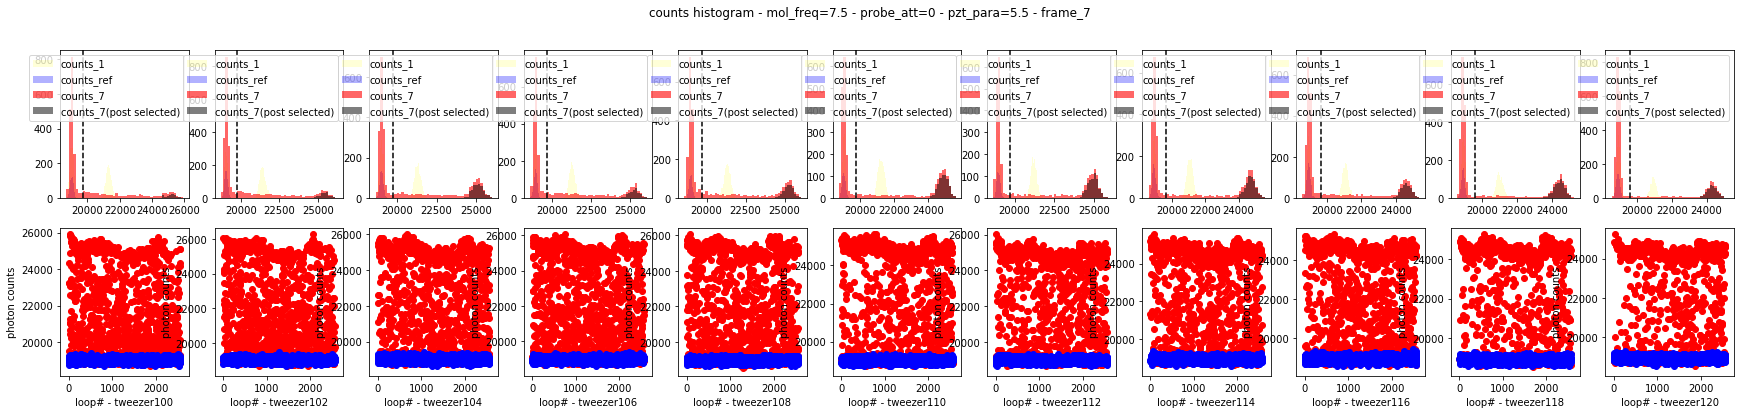

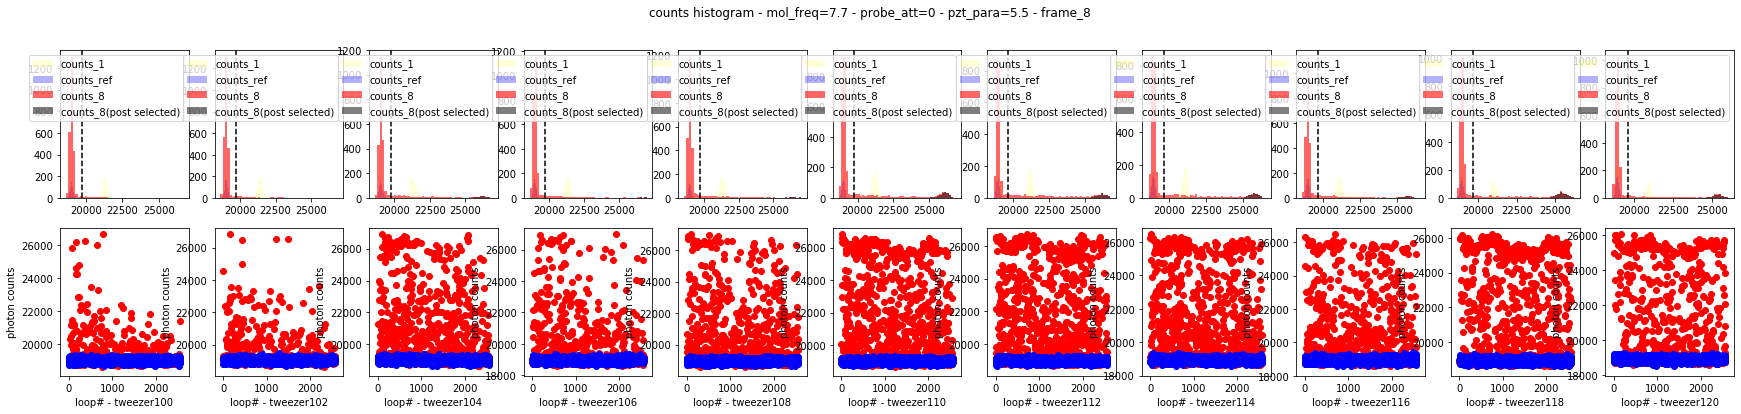

c:\python37-32\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: Mean of empty slice
c:\python37-32\lib\site-packages\numpy\lib\nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


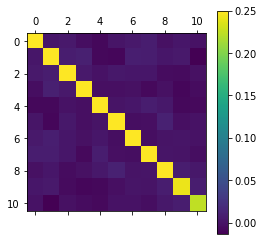

mean_in_theory:5.5, std_in_theory:1.6583123951777
mean:5.62402496099844, std:1.663778576224313
[0, 0]
[1, 6]
[2, 70]
[3, 170]
[4, 423]
[5, 534]
[6, 572]
[7, 469]
[8, 217]
[9, 80]
[10, 22]
[11, 1]


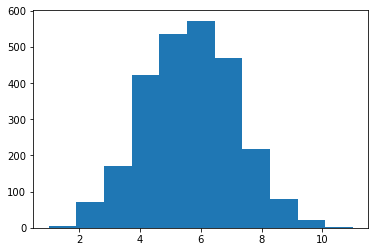

In [5]:
# Calculate cav_brightness and cav_fidelity for every shot!! 
show_plot = True
# zeropeakHWFMper = 1.5
zeropeakHWFMper = 3

cav_brightness = np.zeros((len(mol_freq_list),len(probe_att_list),len(pzt_para_list),len(tweezer_freq_list),num_loops))
cav_fidelity = np.zeros((len(mol_freq_list),len(probe_att_list),len(pzt_para_list),len(tweezer_freq_list),num_loops))
cav_brightness_mov_avg = np.zeros((len(mol_freq_list),len(probe_att_list),len(pzt_para_list),len(tweezer_freq_list),num_loops))
cav_brightness_mov_sigma = np.zeros((len(mol_freq_list),len(probe_att_list),len(pzt_para_list),len(tweezer_freq_list),num_loops))
cav_fidelity_mov_avg = np.zeros((len(mol_freq_list),len(probe_att_list),len(pzt_para_list),len(tweezer_freq_list),num_loops))
cav_fidelity_mov_sigma = np.zeros((len(mol_freq_list),len(probe_att_list),len(pzt_para_list),len(tweezer_freq_list),num_loops))
has_atom = np.zeros((len(mol_freq_list),len(probe_att_list),len(pzt_para_list),len(tweezer_freq_list),num_loops))
atom_number = np.zeros((len(mol_freq_list),len(probe_att_list),len(pzt_para_list),num_loops))

num_avg = 12 # number of loops to put in moving average


ref_counts = counts_array[num_frames-1,:,:,:,:]
base = np.nanmean(ref_counts,3)

upper_threshold = base + 1.2 * zeropeakHWFMper * roi_area

base = np.repeat(base[:,:,:,np.newaxis],num_loops,axis=3)
upper_threshold = np.repeat(upper_threshold[:,:,:,np.newaxis], num_loops, axis=3)

counts_1 = counts_array[0,:,:,:,:]


for frame_num in range(num_frames - 2):
    mol_freq = mol_freq_list[frame_num]
    counts = counts_array[frame_num,:,:,:,:]
    counts_next = counts_array[frame_num+1,:,:,:,:]
    mask = counts_next > upper_threshold
    counts_post_selected = np.where(mask, counts, np.nan)

    atomcenter = np.nanmean(counts_post_selected,3)

    brightness = counts_post_selected - base ## should this be ref_counts (per shot) or base (averaged)
    brightness_sigma = np.nanstd(brightness,3)
    brightness_mean = np.nanmean(brightness,3)

    lower_threshold = atomcenter - 3 * brightness_sigma
    lower_threshold = np.repeat(lower_threshold[:,:,:,np.newaxis], num_loops, axis=3)

    # mask = counts_post_selected > lower_threshold ## getting warning about NaN. 

    mask = np.greater(counts_post_selected, lower_threshold, where=~np.isnan(counts_post_selected))
    counts_postpost_selected = np.where(mask, counts_post_selected, np.nan)
    
    
    for probe_att_counter, probe_att in enumerate(probe_att_list):
        for pzt_para_counter, pzt_para in enumerate(pzt_para_list):
            if show_plot == True:
                fig, ax = plt.subplots(2,num_tweezers, figsize=(30, 6))
                fig.suptitle(f'counts histogram - mol_freq={mol_freq} - probe_att={probe_att} - pzt_para={pzt_para} - frame_{frame_num + 1}')
                    
                for tweezer_freq_counter, tweezer_freq in enumerate(tweezer_freq_list):
#                     print([tweezer_freq_counter, tweezer_freq])
                    bins=50
                    ax[0,tweezer_freq_counter].hist(counts_1[probe_att_counter,pzt_para_counter,tweezer_freq_counter,:], alpha=0.15, color='yellow', bins=bins)
                    ax[0,tweezer_freq_counter].hist(ref_counts[probe_att_counter,pzt_para_counter,tweezer_freq_counter,:], alpha=0.3, color='b', bins=bins)
                    n, bins, patches = \
                    ax[0,tweezer_freq_counter].hist(counts[probe_att_counter,pzt_para_counter,tweezer_freq_counter,:], alpha=0.6, color='r', bins=bins)
                    ax[0,tweezer_freq_counter].hist(counts_postpost_selected[probe_att_counter,pzt_para_counter,tweezer_freq_counter,:], alpha=0.5, color='black', bins=bins)
                    ax[0,tweezer_freq_counter].legend(['counts_1', 'counts_ref', f'counts_{frame_num + 1}', f'counts_{frame_num + 1}(post selected)'])
                    ax[0,tweezer_freq_counter].axvline(upper_threshold[probe_att_counter,pzt_para_counter,tweezer_freq_counter,0], linestyle='--', color='k')
#                     ax[0].axvline(lower_threshold, linestyle='--', color='b')

                    scatter_range = range(num_loops)
                    ax[1,tweezer_freq_counter].scatter(scatter_range, counts[probe_att_counter,pzt_para_counter,tweezer_freq_counter,:], color='r')
                    ax[1,tweezer_freq_counter].scatter(scatter_range, ref_counts[probe_att_counter,pzt_para_counter,tweezer_freq_counter,:], color='b')
                    ax[1,tweezer_freq_counter].set_xlabel(f'loop# - tweezer{tweezer_freq}')
                    ax[1,tweezer_freq_counter].set_ylabel('photon counts')
#                     ax[1,tweezer_freq_counter].legend(['counts', 'counts_ref'])
#                 plt.savefig(Path(save_path, f'mol_freq={mol_freq} - pzt_para={pzt_para_counter} - tweezer={tweezer_counter} - frame_2_pre_selected.png'))
                plt.show()
    
    
    has_atom[frame_num,:,:,:,:] = np.isnan(counts_postpost_selected)
    atom_number[frame_num,:,:,:] = np.count_nonzero(has_atom[frame_num,:,:,:,:], axis = 2)
    atomcenter = np.nanmean(counts_postpost_selected,3)
    brightness = counts_postpost_selected - base ## should this be ref_counts (per shot) or base (averaged)
    brightness_mean = np.nanmean(brightness,3)
    brightness_sigma = np.nanstd(brightness,3)
    
    lower_threshold = atomcenter - 3 * brightness_sigma

    cav_brightness[frame_num,:,:,:,:] = brightness # num_frames x 
    cav_fidelity[frame_num,:,:,:,:] = np.where(counts>upper_threshold,1,0)

cav_brightness_mean = np.nanmean(cav_brightness,4)
cav_brightness_sigma = np.nanstd(cav_brightness,4)
cav_fidelity_mean = np.nanmean(cav_fidelity,4)
cav_fidelity_sigma = np.sqrt(num_loops*cav_fidelity_mean*(1-cav_fidelity_mean))/(num_loops)
for loop in range(num_loops):
    start_temp = np.maximum(np.ceil(loop-num_avg/2).astype(int),0)
    end_temp = np.minimum(np.floor(loop+num_avg/2).astype(int), num_loops)
    cav_brightness_mov_avg[:,:,:,:,loop] = np.nanmean(cav_brightness[:,:,:,:,start_temp:end_temp],4)
    cav_brightness_mov_sigma[:,:,:,:,loop] = np.nanstd(cav_brightness[:,:,:,:,start_temp:end_temp],4)
    cav_fidelity_mov_avg[:,:,:,:,loop] = np.nanmean(cav_fidelity[:,:,:,:,start_temp:end_temp],4)
    cav_fidelity_mov_sigma[:,:,:,:,loop] = np.nanstd(cav_fidelity[:,:,:,:,start_temp:end_temp],4)

covariance_matrix = np.zeros((num_tweezers,num_tweezers))
for ii in range(num_tweezers):
    for jj in range(num_tweezers):
        covariance_matrix[ii,jj] = np.cov(has_atom[0,0,0,ii,:],has_atom[0,0,0,jj,:])[0,1]
plt.matshow(covariance_matrix)
plt.colorbar()
plt.show()

    
plt.hist(atom_number[0,0,0,:],bins=11)
print(f"mean_in_theory:{num_tweezers/2}, std_in_theory:{np.sqrt(num_tweezers/4)}")
print(f"mean:{np.mean(atom_number[0,0,0,:])}, std:{np.std(atom_number[0,0,0,:])}")
for number_atom in range(num_tweezers+1):
    print([number_atom, np.count_nonzero(atom_number[0,0,0,:]==number_atom)])

[ True  True  True  True  True  True  True False]
[ True  True  True  True  True  True  True False]
[ True  True  True  True  True  True  True False]
[ True  True  True  True  True  True  True False]
[ True  True  True  True  True  True  True False]
[ True  True  True  True  True  True  True False]
[ True  True  True  True  True  True  True False]
[ True  True  True  True  True  True  True False]
[ True  True  True  True  True  True  True False]
[ True  True  True  True  True  True  True False]
[ True  True  True  True  True  True  True False]
mol_int:
[0.97512614 0.98709936 0.96621564 0.99082936 1.         0.93898526
 0.9479187  0.90025779 0.89672007 0.88659351 0.85702366]
[0.98195 0.9788  0.98193 0.98034 0.98171 0.98213 0.98161 0.97941 0.98179
 0.98325 0.98081]
[0.92085 0.9288  0.88696 0.82178 0.87438 0.90656 0.91051 0.9156  0.90319
 0.95325 1.     ]


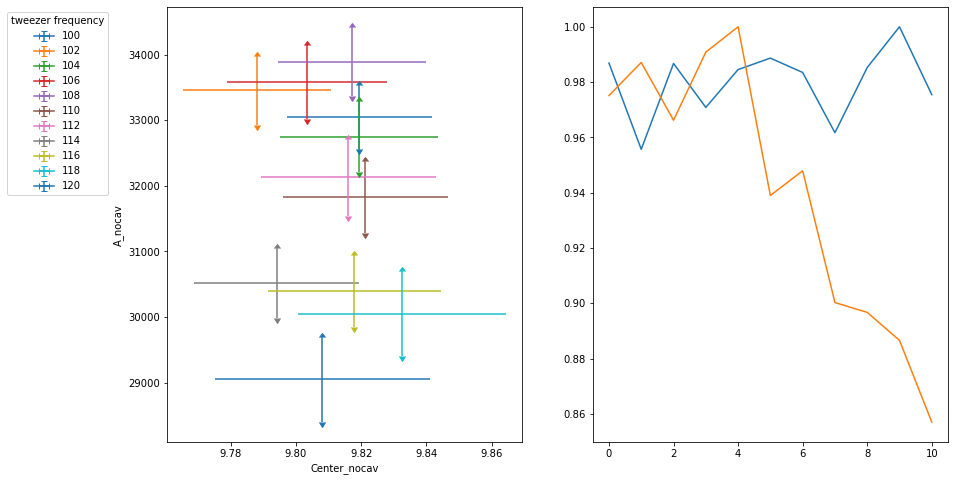

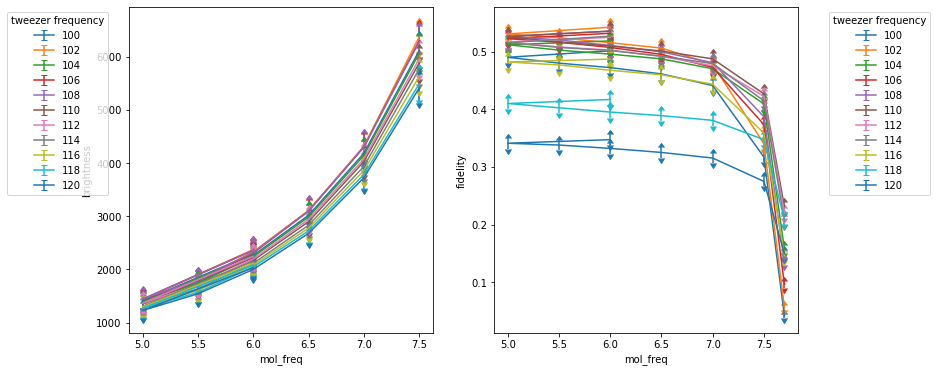

In [6]:

def func(x, a, center):
    return  a / (center-x)**2

fig, ax2 = plt.subplots(1, 2,  figsize=(14, 8))
fig, axs = plt.subplots(1, 2,  figsize=(12, 6))
axs[0].set_xlabel('mol_freq')
axs[0].set_ylabel('brightness')
axs[1].set_xlabel('mol_freq')
axs[1].set_ylabel('fidelity')     
ax2[0].set_xlabel('Center_nocav')
ax2[0].set_ylabel('A_nocav')        
stark = np.zeros(len(tweezer_freq_list))
mol_int = np.zeros(len(tweezer_freq_list))
for tweezer_counter in range(len(tweezer_freq_list)):
    valid = np.logical_and(np.logical_and(np.nanmean(cav_brightness_mean[:, 0, :, tweezer_counter],axis = 1)>0 ,\
                      np.nanmean(cav_brightness_sigma[:, 0, :, tweezer_counter],axis = 1)<500),\
                           np.array(mol_freq_list)<7.7)
    print(valid)
#     valid = ~(np.isnan(np.mean(cav_brightness_mean[:, 0, :, tweezer_counter],axis = 1)) |\
#                       np.isnan(np.mean(cav_brightness_sigma[:, 0, :, tweezer_counter],axis = 1)))
    axs[0].errorbar(np.array(mol_freq_list)[valid], np.nanmean(cav_brightness_mean[valid, 0, :, tweezer_counter],axis = 1), \
                yerr = np.nanmean(cav_brightness_sigma[valid, 0, :, tweezer_counter],axis = 1),  uplims=True, lolims=True, label= f'{tweezer_freq_list[tweezer_counter]}')
    axs[1].errorbar(np.array(mol_freq_list), np.nanmean(cav_fidelity_mean[:, 0, :, tweezer_counter],axis = 1), \
                yerr = np.nanmean(cav_fidelity_sigma[:, 0, :, tweezer_counter],axis = 1),  uplims=True, lolims=True, label= f'{tweezer_freq_list[tweezer_counter]}')
    
    popt, pcov = curve_fit(func, np.array(mol_freq_list)[valid], np.nanmean(cav_brightness_mean[valid, 0, :, tweezer_counter],axis = 1),\
                               sigma = np.mean(cav_brightness_sigma[valid, 0, :, tweezer_counter],axis = 1),\
                           p0=[30000, 10.5], maxfev = 10000)
    a_nocav, center_nocav = popt
    sigma_a_nocav, sigma_center_nocav = np.sqrt(pcov.diagonal())
#     print([[a_nocav,sigma_a_nocav],[center_nocav,sigma_center_nocav]])
    stark[tweezer_counter] = center_nocav/10
    mol_int[tweezer_counter] = a_nocav/10000
    if tweezer_counter < 11:
        ax2[0].errorbar(center_nocav, a_nocav, \
           xerr = sigma_center_nocav, yerr = sigma_a_nocav,  uplims=True, lolims=True, label= f'{tweezer_freq_list[tweezer_counter]}')
    
axs[0].legend(title='tweezer frequency', bbox_to_anchor=(-0.05, 1), loc='upper right')
axs[1].legend(title='tweezer frequency', bbox_to_anchor=(1.45, 1), loc='upper right')
ax2[0].legend(title='tweezer frequency', bbox_to_anchor=(-0.15, 1), loc='upper right')
stark_norm = stark / np.amax(stark[:])
mol_int = mol_int / np.amax(mol_int)
ax2[1].plot(stark_norm**10)
ax2[1].plot(mol_int)
print("mol_int:")
print(mol_int)
order = 2
mag_A_pre = np.array([0.923, 0.925, 0.889, 0.821, 0.876, 0.909, 0.912, 0.913, 0.905, 0.958, 1.   ])
mag_A_post = mag_A_pre / stark**order
mag_A_post = mag_A_post / np.amax(mag_A_post[:])
np.set_printoptions(precision=5,suppress=True)
print(stark)
print(mag_A_post)

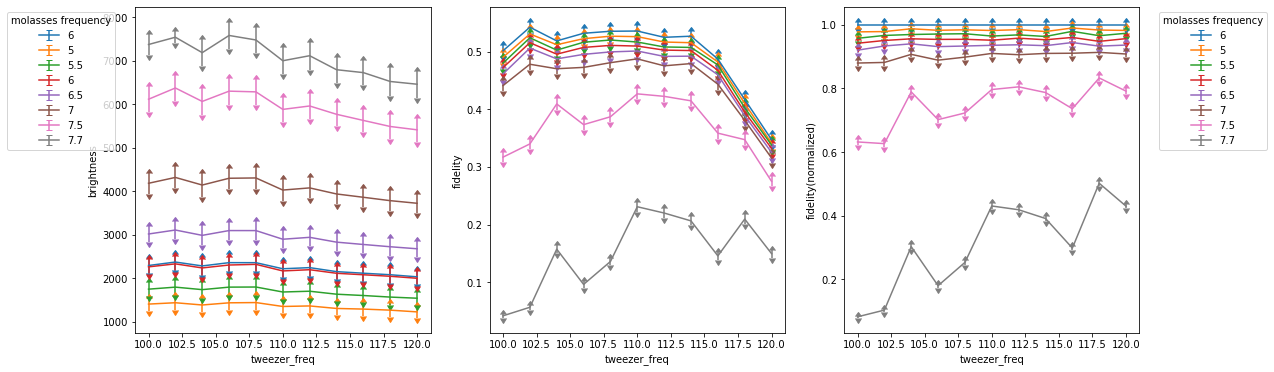

In [7]:

fig, axs = plt.subplots(1, 3,  figsize=(18, 6))
axs[0].set_xlabel('tweezer_freq')
axs[0].set_ylabel('brightness')
axs[1].set_xlabel('tweezer_freq')
axs[1].set_ylabel('fidelity')  
axs[2].set_xlabel('tweezer_freq')
axs[2].set_ylabel('fidelity(normalized)')        
for mol_counter in range(len(mol_freq_list)):
    axs[0].errorbar(np.array(tweezer_freq_list), np.mean(cav_brightness_mean[mol_counter, 0, :, :],axis = 0), \
                yerr = np.mean(cav_brightness_sigma[mol_counter, 0, :, :],axis = 0),  uplims=True, lolims=True, label= f'{mol_freq_list[mol_counter]}')
    axs[1].errorbar(np.array(tweezer_freq_list), np.mean(cav_fidelity_mean[mol_counter, 0, :, :],axis = 0), \
                yerr = np.mean(cav_fidelity_sigma[mol_counter, 0, :, :],axis = 0),  uplims=True, lolims=True, label= f'{mol_freq_list[mol_counter]}')
    axs[2].errorbar(np.array(tweezer_freq_list), np.mean(cav_fidelity_mean[mol_counter, 0, :, :],axis = 0)/np.mean(cav_fidelity_mean[0, 0, :, :],axis = 0), \
                yerr = np.mean(cav_fidelity_sigma[mol_counter, 0, :, :],axis = 0),  uplims=True, lolims=True, label= f'{mol_freq_list[mol_counter]}')
    
axs[0].legend(title='molasses frequency', bbox_to_anchor=(-0.05, 1), loc='upper right')
axs[2].legend(title='molasses frequency', bbox_to_anchor=(1.45, 1), loc='upper right')